In [1]:
from exact_diag import antiperiodic_ham, np, form_basis, quantum_operator, spinful_fermion_basis_1d, reduce_state
from exact_diag import quartet_wavefunction, iso_wavefunction, casimir_dict, find_nk, ham_op_2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Defining various $S^2$ operators

I need to keep in mind the following:
\begin{align*}
\sum_{k,k'>0}S_{k}^+ S_{k'}^- =& \sum_{k,k'>0}(c_{k\uparrow}^\dagger c_{k\downarrow} + c_{-k\uparrow}^\dagger c_{-k\downarrow})
(c_{k'\downarrow}^\dagger c_{k'\uparrow} + c_{-k'\downarrow}^\dagger c_{-k'\uparrow})\\
=&\sum_{k,k'}c_{k\uparrow}^\dagger c_{k\downarrow}c_{k'\downarrow}^\dagger c_{k'\uparrow}
=\sum_{k,k'}c_{k\uparrow}^\dagger c_{k'\uparrow} c_{k\downarrow} c_{k'\downarrow}^\dagger\\
\sum_{k,k'>0}S_{k}^z S_{k'}^z =&
\frac{1}{4}\sum_{k,k'>0}(n_{k\uparrow}+ n_{-k\uparrow}-n_{k\downarrow} - n_{-k\downarrow})
(n_{k'\uparrow}+ n_{-k'\uparrow}-n_{k'\downarrow} - n_{-k'\downarrow})\\
=&\frac{1}{4}\sum_{k,k'}(n_{k\uparrow} - n_{k\downarrow})(n_{k'\uparrow} - n_{k'\downarrow})\\
=&\frac{1}{4}\sum_{k,k'}(  n_{k\uparrow} n_{k'\uparrow} 
                         - n_{k\uparrow} n_{k'\downarrow}
                         - n_{k'\uparrow} n_{k\downarrow}
                         + n_{k\downarrow} n_{k'\downarrow}).
\end{align*}
Then,
\begin{align*}
\sum_{k,k'>0}\vec S_k \cdot \vec S_{k'}
=& \frac{1}{2}\sum_{k,k'} \left(
c_{k\uparrow}^\dagger c_{k'\uparrow} c_{k\downarrow} c_{k'\downarrow}^\dagger
+ c_{k\uparrow} c_{k'\uparrow}^\dagger c_{k\downarrow}^\dagger c_{k'\downarrow}
+ \frac{1}{2} \left(n_{k\uparrow} n_{k'\uparrow} + n_{k\downarrow} n_{k'\downarrow}
- n_{k\uparrow} n_{k'\downarrow} - n_{k'\uparrow} n_{k\downarrow}\right)
\right)
\end{align*}
The other thing we care about (maybe??) is $\sum_{k>0} S_k^2 = \sum_{k,k'>0}\delta_{kk'}S_k \cdot \vec S_{k'}$:
\begin{align*}
\sum_{k}\vec S_k \cdot \vec S_k
=& \frac{1}{2}
\end{align*}

In [2]:
def sk2(l, k, basis, s=1):
    # Operator for S.S = 0.5(S^+ S^- + S^- S^+) + S^z S^z
    p_k1 = l + k
    m_k1 = l - k - 1
    spm = [[0.5*s, p_k1, p_k1, p_k1, p_k1],
           [0.5*s, p_k1, m_k1, p_k1, m_k1],
           [0.5*s, m_k1, p_k1, m_k1, p_k1],
           [0.5*s, m_k1, m_k1, m_k1, m_k1]]
    sz_p = [[0.25*s, p_k1, p_k1],
            [0.25*s, m_k1, m_k1],
            [0.25*s, p_k1, m_k1],
            [0.25*s, m_k1, p_k1]
           ]
    sz_n = [[-.5*s, p_k1, p_k1],
            [-.5*s, p_k1, m_k1],
            [-.5*s, m_k1, p_k1],
            [-.5*s, m_k1, m_k1]]
    sdict = {'static':[['+-|-+', spm],
                       ['-+|+-', spm],
                       ['nn|', sz_p],
                       ['|nn', sz_p],
                       ['n|n', sz_n]]}
    return quantum_operator(sdict, basis=basis)


def total_S2_op(L, basis, s=1.):
    op_lst = []
    for i in range(L):
        for j in range(L):
            op_lst += [['+-|-+', [[s/2, L+i, L+j, L+i, L+j],
                                 [s/2, L+i, L-1-j, L+i, L-1-j],
                                 [s/2, L-1-i, L+j, L-1-i, L+j],
                                 [s/2, L-1-i, L-1-j, L-1-i, L-1-j]]],
                       ['-+|+-', [[s/2, L+i, L+j, L+i, L+j],
                                  [s/2, L+i, L-1-j, L+i, L-1-j],
                                  [s/2, L-1-i, L+j, L-1-i, L+j],
                                  [s/2, L-1-i, L-1-j, L-1-i, L-1-j]]],
                      ['nn|', [[s/4, L+i, L+j],
                               [s/4, L+i, L-1-j],
                               [s/4, L-1-i, L+j],
                               [s/4, L-1-i, L-1-j]]],
                      ['|nn', [[s/4, L+i, L+j],
                               [s/4, L+i, L-1-j],
                               [s/4, L-1-i, L+j],
                               [s/4, L-1-i, L-1-j]]],
                      ['n|n', [[-s/4, L+i, L+j],
                               [-s/4, L+i, L-1-j],
                               [-s/4, L-1-i, L+j],
                               [-s/4, L-1-i, L-1-j],
                               [-s/4, L+j, L+i],
                               [-s/4, L+j, L-1-i],
                               [-s/4, L-1-j, L+i],
                               [-s/4, L-1-j, L-1-i]]]
                      ]
        op = quantum_operator({'static': op_lst}, basis=basis,
                                check_herm=False, check_symm=False,
                                check_pcon=False)    
        return op

def ke_op(l, s, k, basis):
    all_k = np.concatenate((k[::-1], k))
    creation_lst = [[s*all_k[i], i] for i in range(l)]
    return quantum_operator({'static': [['n|', creation_lst], ['|n', creation_lst]]}, basis=basis,
                                   check_herm=False, check_symm=False, check_pcon=False)

# Energy at $G_c$

What are the ioms at $G_c$? Let's assume $e_\alpha = s_k  = \nu_k = 0$:
\begin{align*}
r_k  = - 1.
\end{align*}
Then,
\begin{align*}
E_0(G_c) =&\lim_{q\rightarrow\infty} \frac{2}{1+q/G_c}\left(\sum_k \eta_k r_k -\Gamma\right)\\
=&\lim_{q\rightarrow\infty} \frac{2}{1+q/G_c}\left(-\frac{1}{G_c} - \sum_k \eta_k \left(1+ \frac{1}{2}\frac{q}{G_c}
+ \frac{q}{2}\eta_k t_k^2
\right)\right)\\
=&\lim_{q\rightarrow\infty} \frac{2}{1+q/G_c}\left(-\frac{1}{G_c} - \frac{1}{G_c} -\frac{1}{2}\frac{q}{G_c}
-\frac{q}{2}\sum_k \eta_k^2 t_k^2
\right)\\
\end{align*}
Dropping terms without a $q$ top and bottom,
\begin{align*}
E_0(G_c) 
=&\lim_{q\rightarrow\infty} \frac{2}{q/G_c}\left(-\frac{1}{2}\frac{q}{G_c}
-\frac{q}{2}\sum_k \eta_k^2 t_k^2
\right)\\
=&- G_c\left(1/G_c + \sum_k \eta_k^2 t_k^2
\right)\\
=& -1 - G_c \sum_k \eta_k^2 t_k^2
\end{align*}
If we keep all dangling ones, this seems correct. I for the most part eliminate these danglers

Now, let's have $N$ odd, so for some $k=k_m$, $\nu_{k_m}=1$ and $s_{k_m} = \pm 0.5$.
Then,
\begin{align*}
r_{k_m} = \frac{1}{2}-1 \pm \frac{q}{2}\sum_\beta Z_{k\beta}
-q \sum_{k'\neq k_m}\left(
-\left(\frac{1}{2}-1\right)
\right)Z_{k_m k'}
=-1 +\left( \frac{1}{2} \pm \frac{q}{2}\sum_\beta Z_{k\beta}
- \frac{q}{2}\sum_{k'\neq k_m}Z_{k_m k'}\right)
\end{align*}
For $k \neq k_m$, $r_k = -1$ as before. 
Then,
\begin{align*}
E_0(G_c) =&\lim_{q\rightarrow\infty} \frac{2}{1+q/G_c}\left(\sum_k \eta_k r_k -\Gamma\right)\\
=&\lim_{q\rightarrow\infty} \frac{2}{1+q/G_c}\left(-\frac{1}{G_c}
+ \eta_{k_m}\left(\frac{1}{2} - \frac{q}{2}\sum_{k'\neq k_m} Z_{k_m k'}\right)
- \sum_k \eta_k \left(1+ \frac{1}{2}\frac{q}{G_c}
+ \frac{q}{2}\eta_k t_k^2
\right)\right)\\
=&E_\text{even}
+ \eta_{k_m}\lim_{q\rightarrow\infty}\frac{2}{1+q/G_c}\left(\frac{1}{2} - \frac{q}{2}\sum_{k'\neq k_m} Z_{k_m k'}\right)\\
=& E_\text{even}
-\eta_{k_m}\lim_{q\rightarrow\infty}G_c\sum_{k'\neq k_m}Z_{k_m k'}
\end{align*}

In [3]:
L = 8
l = L//2
Nup = 3
Ndown = 2
Sz = .5*(Nup-Ndown)
N = Nup+Ndown
if N%2 == 0:
    degen = (N-2*np.abs(Sz)+4)*.25
else:
    degen = N - 2*np.abs(Sz)+2
k = np.arange(1, 2*l+1, 2)*0.5*np.pi/l
Gc = 1./np.sum(k)
basis = spinful_fermion_basis_1d(L, Nf=(Nup, Ndown))

h = antiperiodic_ham(l, Gc, basis)
e, v = h.eigsh(k=10, which='SA')

s2_tot = total_S2_op(l, basis)
# ss, _ = s2_tot.eigh()
# print(np.unique(np.round(ss, 2)))
sops = [sk2(l, i, basis, s=1) for i in range(l)]


print('')
print('Degeneracy')
print(len(e[np.abs(e-e[0]) < 10**-6]))
print('Prediction')
print(degen)
print('Energy')
print(e[0])

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!

Degeneracy
6
Prediction
6.0
Energy
-5.780039608753137


In [4]:
e_even = -3*Gc*np.sum(k**2)
print(e_even)

-6.1850105367549055


In [5]:
def Z(a,b):
    return a*b/(a-b)

In [6]:
e_odd = Gc*k[1]*(1./Gc+.5*k[1])
vs_odd = np.zeros(l)
vs_odd[1] = 1
ss_odd = np.zeros(l)
ss_odd[1] = 0.5
def ck(vs, ss):
    cks = ss*(ss+1)+(.5*vs-1)**2+3*(1-.5*vs)-1
    return cks
cs = ck(vs_odd, ss_odd)
e_odd = -Gc*np.sum(cs*k**2)  - k[1]*Gc*np.sum(Z(k[1], k[np.arange(l) != 1]))
e_odd_2 = e_even  + k[0]*(1+.5*Gc*k[0])
print(e_odd)
print(e_odd_2)

-5.025321061113361
-5.780039608753096


In [8]:
L = 8
l = L//2
Nup = 2
Ndown = 2
Sz = .5*(Nup-Ndown)
N = Nup+Ndown
pscales = np.arange(-1, 1.25, .25)
labels = ['S2', 'Gt', 'Gs', 'Gn', 'Gn_2']
es_all = [{l: np.zeros(len(pscales)) for l in labels} for i in range(5)]
es_kin = [{l: np.zeros(len(pscales)) for l in labels} for i in range(5)]
Ns = [N+2, N+1, N, N-1, N-2]
bases = [spinful_fermion_basis_1d(2*l, Nf=(N//2+N%2, N//2)) for N in Ns]
v0s = []
for i, b in enumerate(bases):
    h0 = ham_op_2(L//2, 0, k, b)
    e0, v0 = h0.eigsh(k=1, which='SA')
    v0s += [v0[:, 0]]

"""
print('Adding S^2')
for i, p in enumerate(tqdm(pscales)):
    for j, b in enumerate(bases):
        perturb_op = total_S2_op(l, b, s=p)
        hp = antiperiodic_ham(l, Gc, b) + perturb_op
        if b.Ns < 3000:
            ep, vp = hp.eigh() 
        else:
            ep, vp = hp.eigsh(k=10, which='SA')
        es_all[j]['S2'][i] = ep[0]
"""
    
    
print('Scaling G_t')
for i, p in enumerate(tqdm(pscales)):
    for j, b in enumerate(bases):
        hp = ham_op_2(l, Gc, k, b, couplings=(1.+p,1.,1.))
        if b.Ns < 1000:
            ep, vp = hp.eigh() 
        else:
            ep, vp = hp.eigsh(k=4, which='SA')
        es_all[j]['Gt'][i] = ep[0]
        es_kin[j]['Gt'][i] = np.real(hp.matrix_ele(v0s[j], v0s[j]))

print('Scaling G_s')
for i, p in enumerate(tqdm(pscales)):
    for j, b in enumerate(bases):
        hp = ham_op_2(l, Gc, k, b, couplings=(1.,1.+p,1.))
        if b.Ns < 1000:
            ep, vp = hp.eigh() 
        else:
            ep, vp = hp.eigsh(k=4, which='SA')
        es_all[j]['Gs'][i] = ep[0]
        es_kin[j]['Gs'][i] = np.real(hp.matrix_ele(v0s[j], v0s[j]))

print('Scaling G_n')
for i, p in enumerate(tqdm(pscales)):
    for j, b in enumerate(bases):
        hp = ham_op_2(l, Gc, k, b, couplings=(1.,1.,1.+p))
        if b.Ns < 1000:
            ep, vp = hp.eigh() 
        else:
            ep, vp = hp.eigsh(k=4, which='SA')
        es_all[j]['Gn'][i] = ep[0]
        es_kin[j]['Gn'][i] = np.real(hp.matrix_ele(v0s[j], v0s[j]))

print('Scaling G_n with correction')
for i, p in enumerate(tqdm(pscales)):
    for j, b in enumerate(bases):
        hp = ham_op_2(l, Gc, k, b, couplings=(1.,1.,1.+p))
        hp += ke_op(l, p, k, b)
        if b.Ns < 1000:
            ep, vp = hp.eigh() 
        else:
            ep, vp = hp.eigsh(k=4, which='SA')
        es_all[j]['Gn_2'][i] = ep[0]
        es_kin[j]['Gn_2'][i] = np.real(hp.matrix_ele(v0s[j], v0s[j]))


  0%|          | 0/9 [00:00<?, ?it/s]

Scaling G_t


  0%|          | 0/9 [00:00<?, ?it/s]

Scaling G_s


  0%|          | 0/9 [00:00<?, ?it/s]

Scaling G_n


  0%|          | 0/9 [00:00<?, ?it/s]

Scaling G_n with correction


100%|██████████| 9/9 [00:19<00:00,  2.14s/it]


9


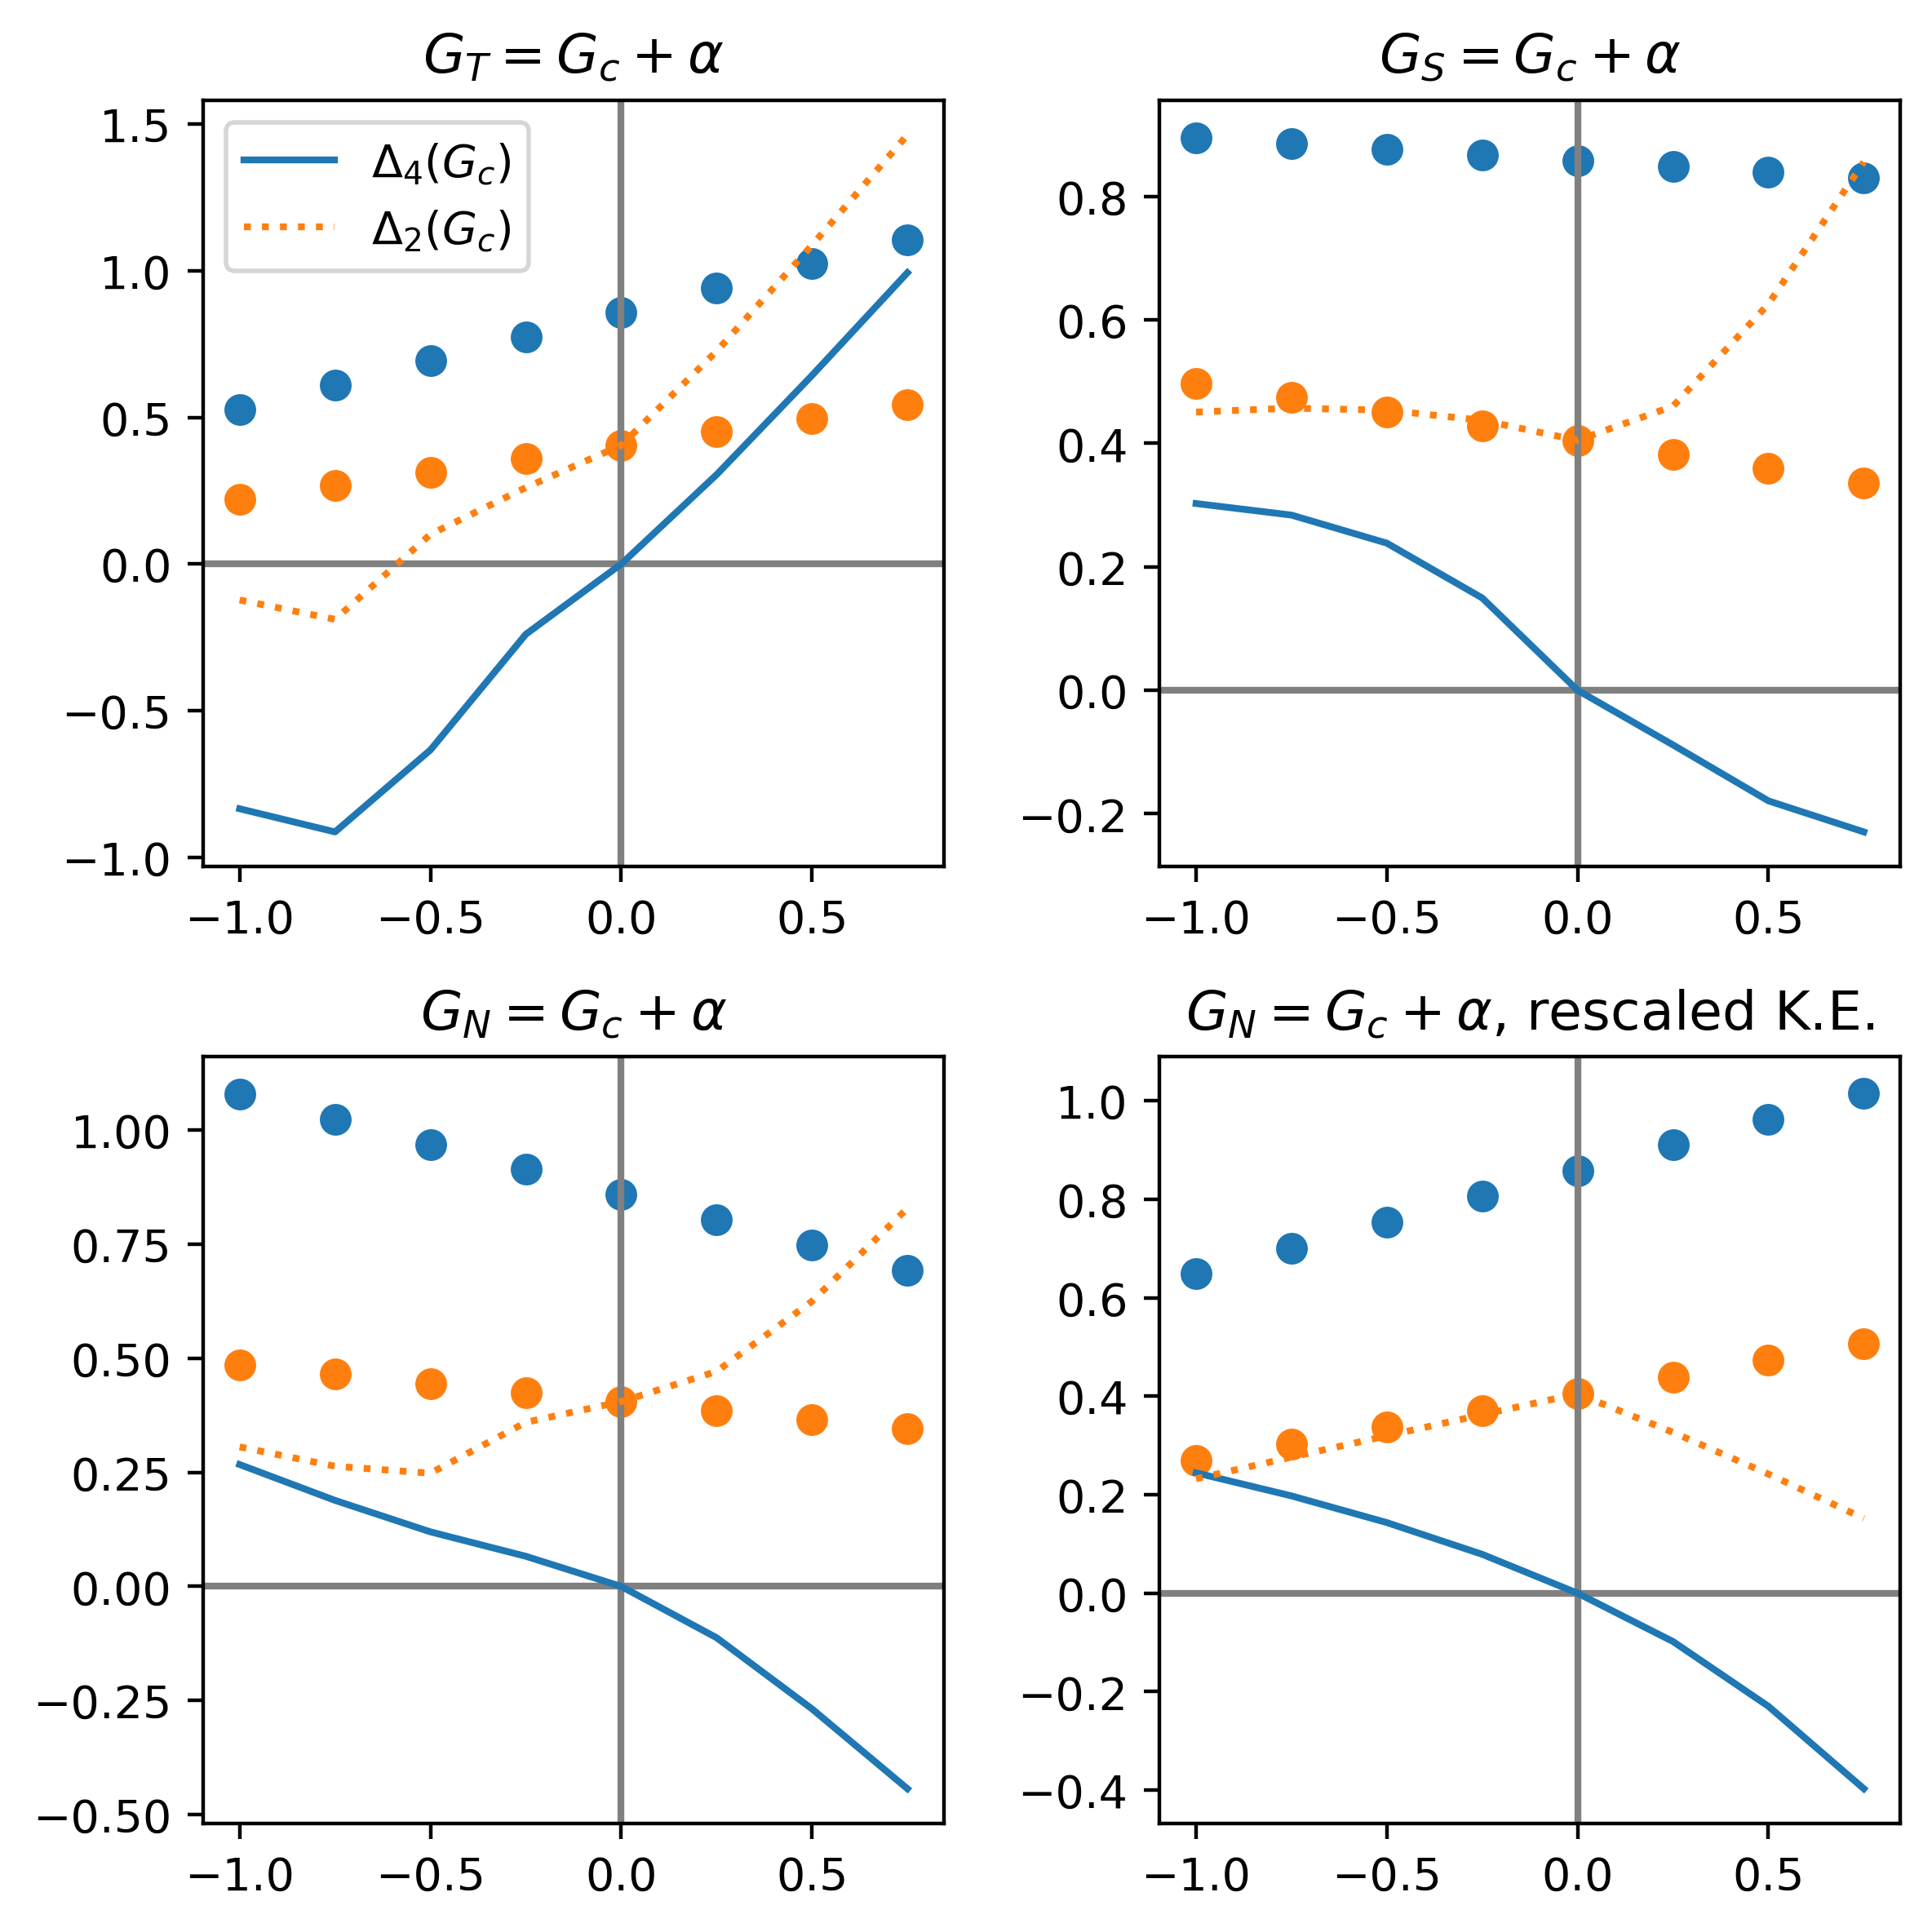

In [9]:
plt.figure(figsize=(6,6), dpi=400)
pscales = np.arange(-1, 1.25, .25)
print(len(pscales))
titles = [r'$S^2$ perturbation', r'$G_T = G_c+\alpha$', r'$G_S = G_c+\alpha$', r'$G_N = G_c+\alpha$', r'$G_N = G_c+\alpha$, rescaled K.E.']
sp = 1
for i in range(5):
    la = labels[i]
    qs = 0.5*(es_all[0][la]+es_all[4][la]-2*es_all[2][la])
    ps = 0.5*(es_all[1][la]+es_all[3][la]-2*es_all[2][la])
    qsk = 0.5*(es_kin[0][la]+es_kin[4][la]-2*es_kin[2][la])
    psk = 0.5*(es_kin[1][la]+es_kin[3][la]-2*es_kin[2][la])
    if la != 'S2':
        plt.subplot(2,2, sp)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.plot(pscales[:-1], qs[:-1], label=r'$\Delta_4(G_c)$')
        plt.plot(pscales[:-1], ps[:-1], ls=':', label=r'$\Delta_2(G_c)$')
        plt.scatter(pscales[:-1], qsk[:-1])
        plt.scatter(pscales[:-1], psk[:-1])
        plt.title(titles[i])
        sp += 1

    if la == 'Gt':
        plt.legend()
plt.tight_layout(pad=1.0)
plt.savefig('gaps_L{}N{}.png'.format(2*l, Nup+Ndown))

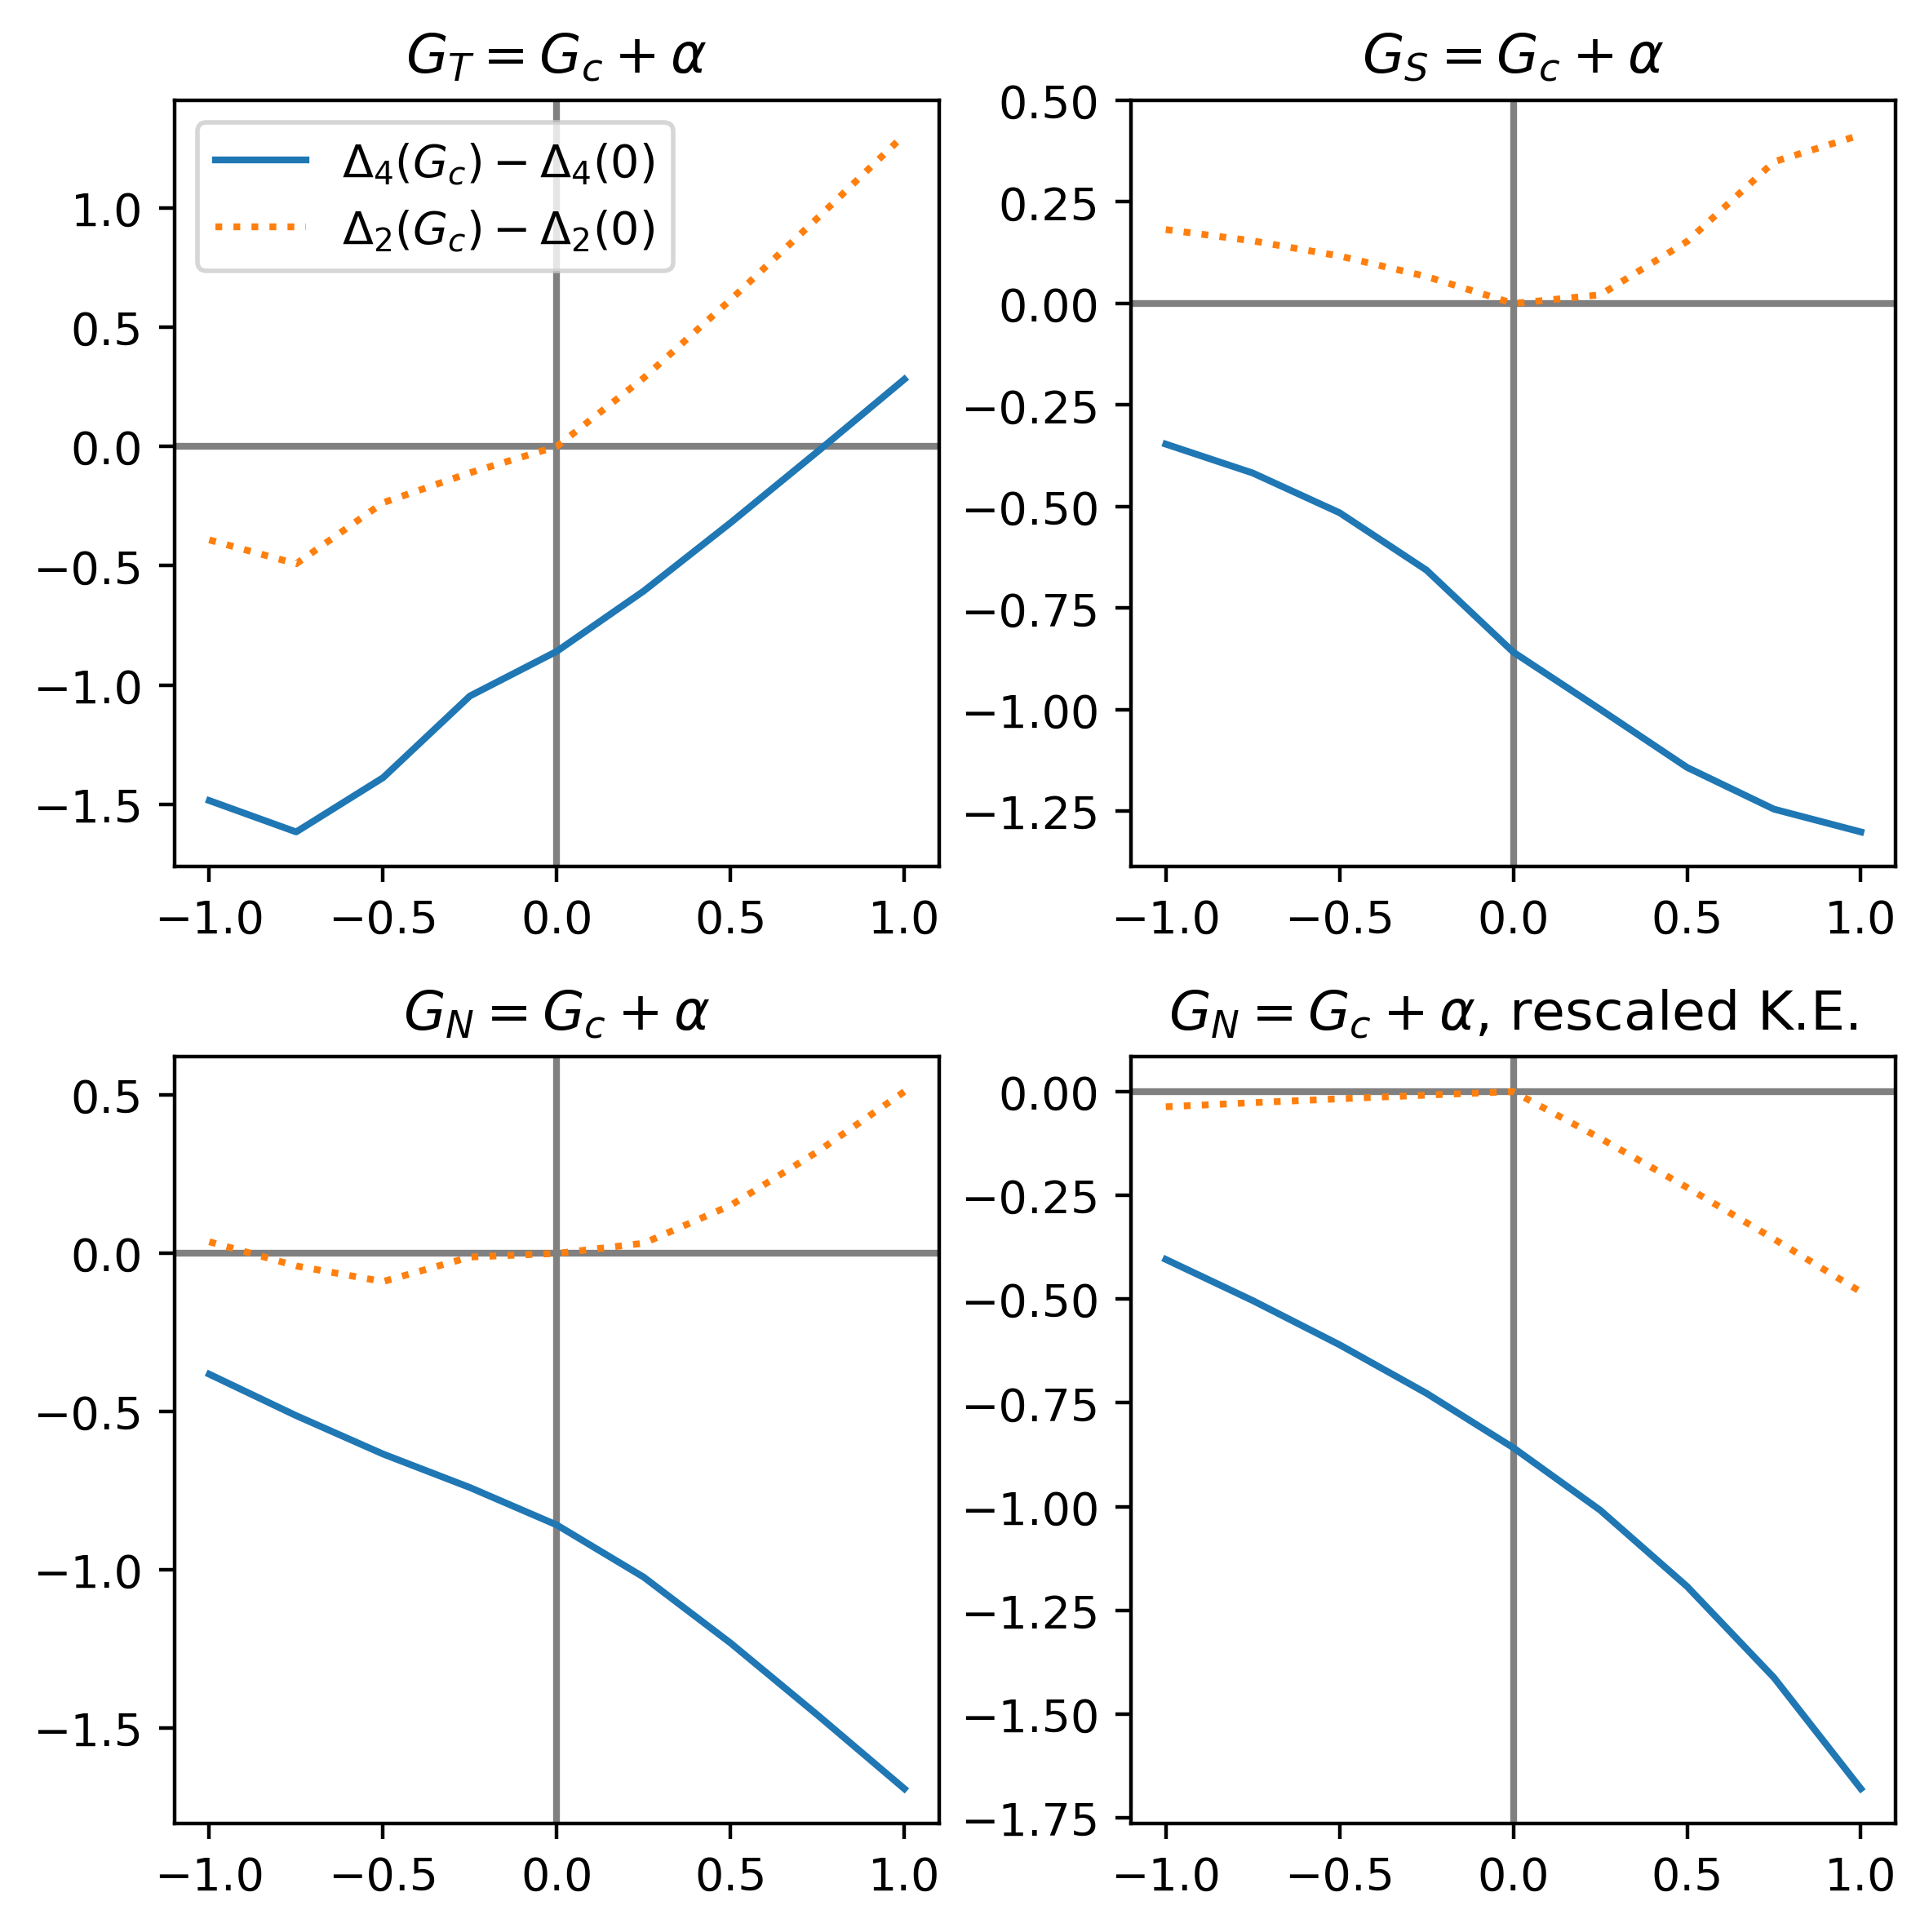

In [11]:
plt.figure(figsize=(6,6), dpi=400)
titles = [r'$S^2$ perturbation', r'$G_T = G_c+\alpha$', r'$G_S = G_c+\alpha$', r'$G_N = G_c+\alpha$', r'$G_N = G_c+\alpha$, rescaled K.E.']
sp = 1
q_kin = k[N//2-1]-k[N//2-2]
p_kin = .5*q_kin
for i in range(5):
    la = labels[i]
    qs = 0.5*(es_all[0][la]+es_all[4][la]-2*es_all[2][la])
    ps = 0.5*(es_all[1][la]+es_all[3][la]-2*es_all[2][la])
    if la != 'S2':
        plt.subplot(2,2, sp)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.plot(pscales, qs-qsk, label=r'$\Delta_4(G_c) - \Delta_4(0)$')
        plt.plot(pscales, ps-psk, ls=':', label=r'$\Delta_2(G_c) - \Delta_2(0)$')
        plt.title(titles[i])
        sp += 1

    if la == 'Gt':
        plt.legend()
plt.tight_layout(pad=1.0)
plt.savefig('gaps_minus_ke_L{}N{}.png'.format(2*l, Nup+Ndown))

In [2]:
L = 8
l = L//2
Nup = 2
Ndown = 2
Sz = .5*(Nup-Ndown)
N = Nup+Ndown
k = np.arange(1, 2*l+1, 2)*0.5*np.pi/l
Gc = 1./np.sum(k)
Gs = np.arange(0, 1.75, .25)*Gc
labels = ['all', 'no_dd', 'no_ss', 'pairing']
couplings = [(1., 1., 1.), (1., 1., 0), (1., 0., 1.), (1., 0., 0.)]
e_all = [{l: np.zeros(len(Gs)) for l in labels} for i in range(5)]
e_kin = [{l: np.zeros(len(Gs)) for l in labels} for i in range(5)]


Ns = [N+2, N+1, N, N-1, N-2]
bases = [spinful_fermion_basis_1d(2*l, Nf=(N//2+N%2, N//2)) for N in Ns]
v0s = []
for i, b in enumerate(bases):
    h0 = ham_op_2(L//2, 0, k, b)
    e0, v0 = h0.eigh()
    v0s += [v0[:, 0]]

In [ ]:
print(Ns)
for Gi, G in enumerate(Gs):
    print('G/Gc = {}'.format(G/Gc))
    for bi, b in enumerate(tqdm(bases)):
        for ci, c in enumerate(couplings):
            hp = ham_op_2(l, G, k, b, couplings=c)
            if b.Ns < 4000:
                ep, vp = hp.eigh() 
            else:
                ep, vp = hp.eigsh(k=40, which='SA')
            e_all[bi][labels[ci]][Gi] = ep[0]
            e_kin[bi][labels[ci]][Gi] = np.real(hp.matrix_ele(v0s[bi], v0s[bi]))

  0%|          | 0/5 [00:00<?, ?it/s]

[6, 5, 4, 3, 2]
G/Gc = 0.0


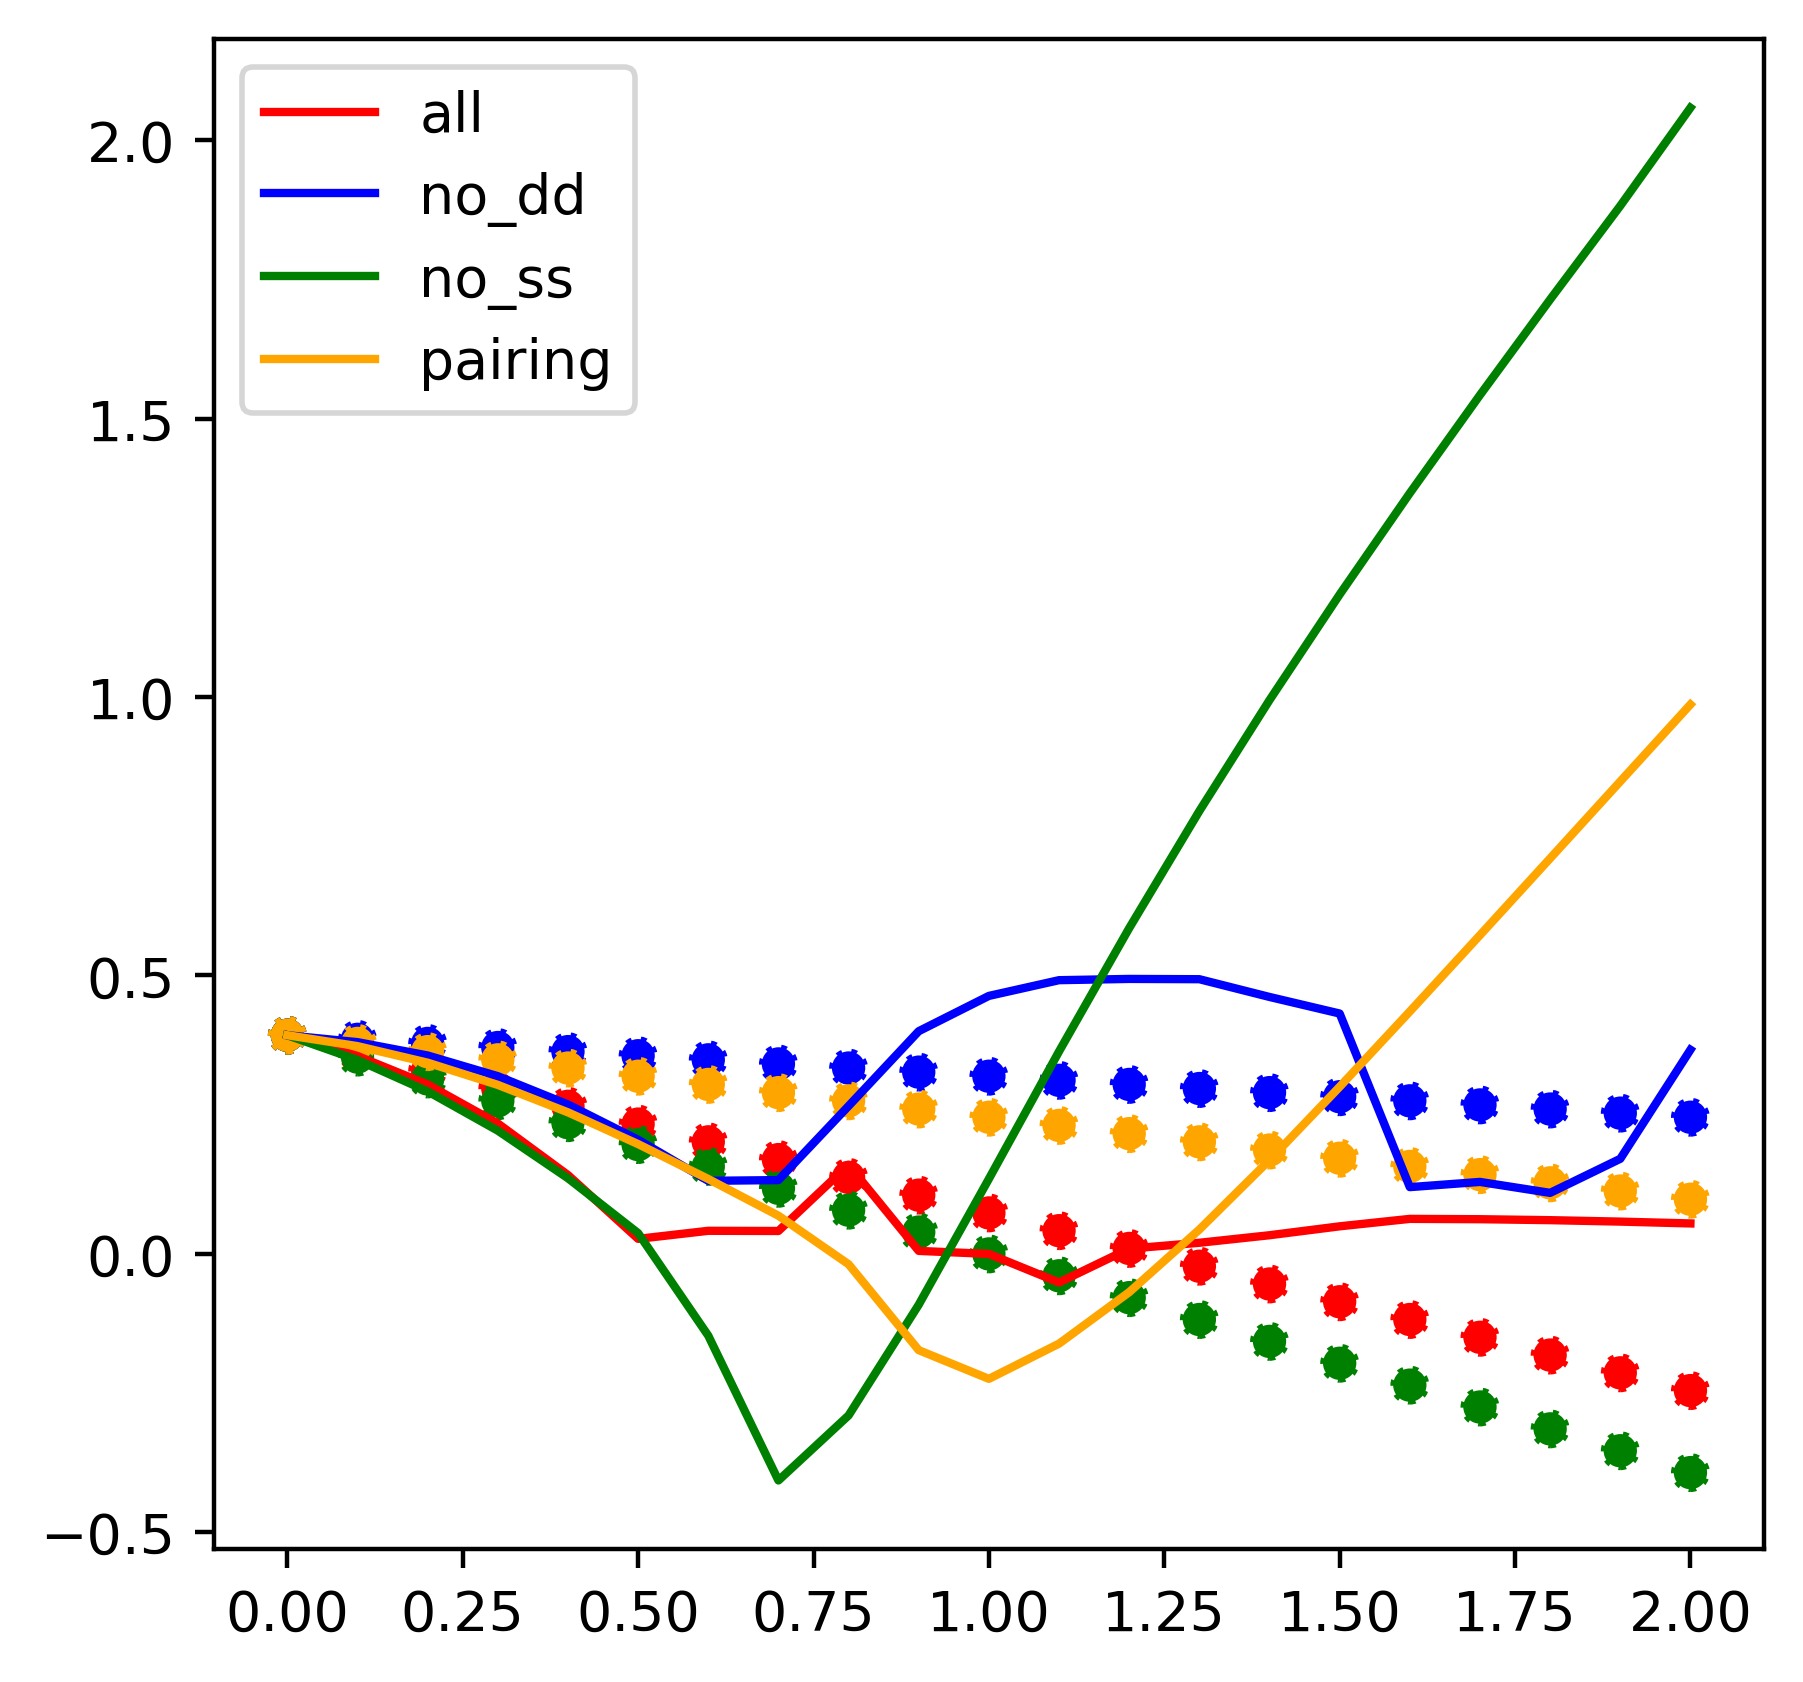

In [6]:
colors = ['red', 'blue', 'green', 'orange']
plt.figure(figsize=(5,5), dpi=400)
for li, la in enumerate(labels):
    qg = (e_all[0][la] + e_all[4][la] - 2*e_all[2][la])/2
    pg = (e_all[1][la] + e_all[3][la] - 2*e_all[2][la])/2
    qgk = (e_kin[0][la] + e_kin[4][la] - 2*e_kin[2][la])/2
    pgk = (e_kin[1][la] + e_kin[3][la] - 2*e_kin[2][la])/2
    plt.plot(Gs/Gc, qg, label=la, color=colors[li])
    # plt.plot(Gs/Gc, pg, label=la, color=colors[li], ls=':')
    plt.scatter(Gs/Gc, qgk, color=colors[li], ls=':')
    # plt.scatter(Gs/Gc, pgk, color=colors[li], ls=':')
plt.legend()
plt.show()

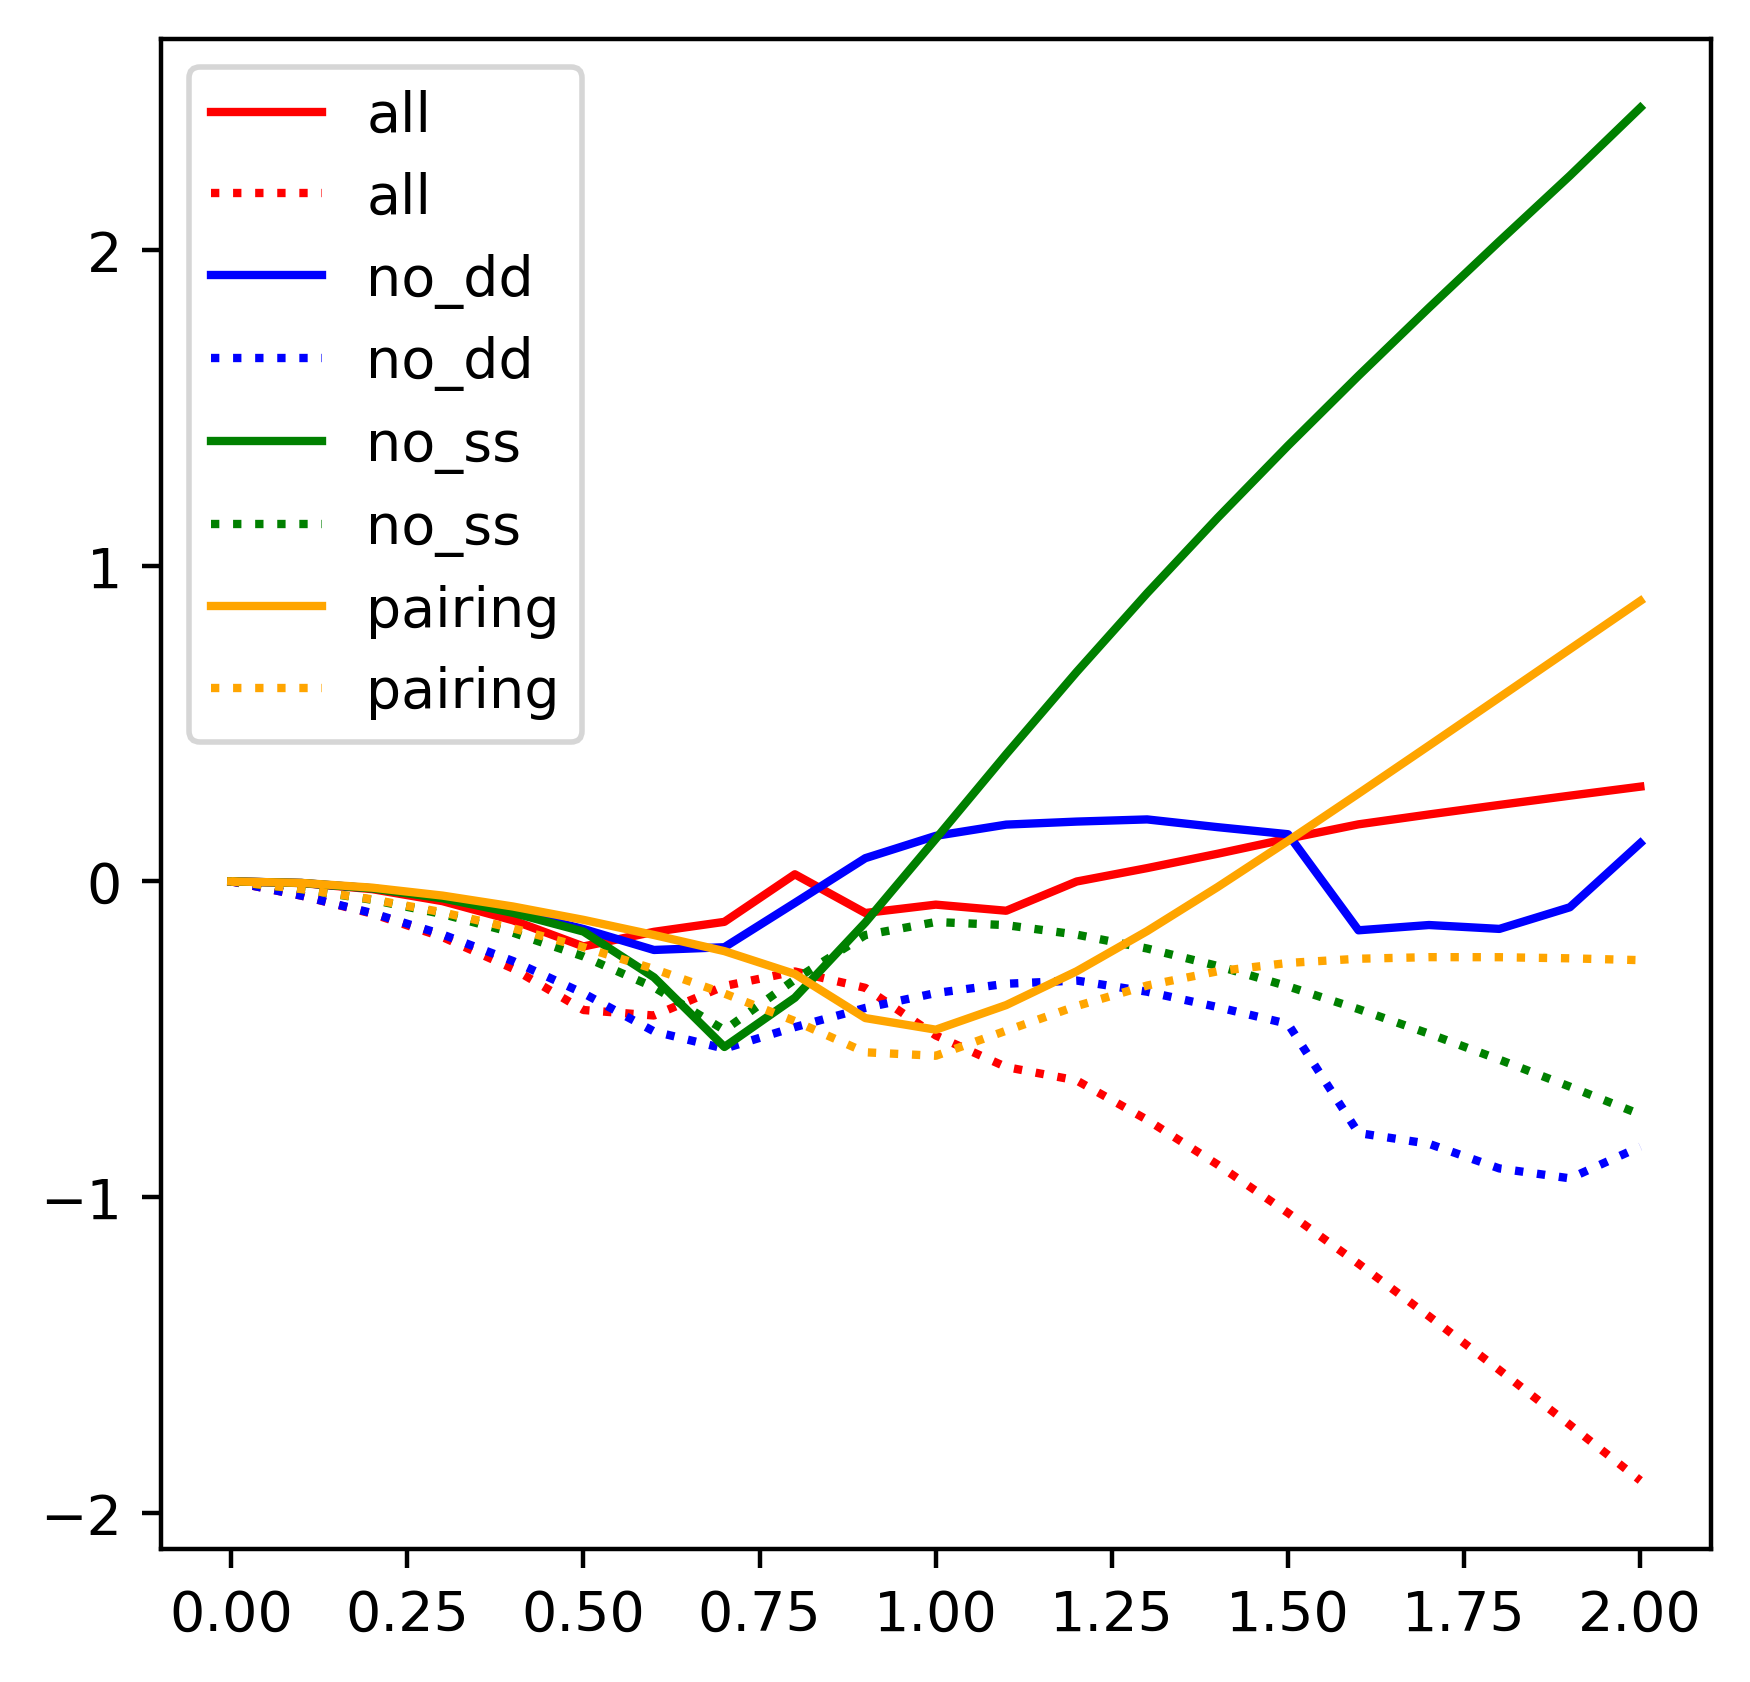

In [7]:
colors = ['red', 'blue', 'green', 'orange']
plt.figure(figsize=(5,5), dpi=400)
for li, la in enumerate(labels):
    qg = (e_all[0][la] + e_all[4][la] - 2*e_all[2][la])/2
    pg = (e_all[1][la] + e_all[3][la] - 2*e_all[2][la])/2
    qgk = (e_kin[0][la] + e_kin[4][la] - 2*e_kin[2][la])/2
    pgk = (e_kin[1][la] + e_kin[3][la] - 2*e_kin[2][la])/2
    plt.plot(Gs/Gc, qg-qgk, label=la, color=colors[li])
    plt.plot(Gs/Gc, pg-pgk, label=la, color=colors[li], ls=':')
    # plt.scatter(Gs/Gc, qgk, color=colors[li], ls=':')
    # plt.scatter(Gs/Gc, pgk, color=colors[li], ls=':')
plt.legend()
plt.show()

## Critical point in the attractive case
We are studying the Hamiltonian
\begin{equation}
H = \sum_k \epsilon_k N_k - G\sum_{k,k'}\eta_k \eta_{k'}\left(
\vec T_k^+ \cdot \vec T_{k'}^-
+ \vec T_k^- \cdot \vec T_{k'}^+
+ \vec S_k \cdot \vec S_{k'}
+ \frac{1}{4}N_k N_{k'}
\right).
\end{equation}
with $\eta_k = \epsilon_k = k$.

For attractive ($G > 0$) couplings, this Hamiltonian has a unique ground state except at the critical point
$G_c = 1/\sum_k\eta_k$, at which point the degeneracy seems to scale logarithmically with $N$.
For $N > 4$, one of the ground state wavefunctions has a quartet form.

In [ ]:
def gen_crit_wf(l, Nq, Np, basis, basisf):
    alpha=-.5
    # vacuum state
    v0 = np.zeros(basisf.Ns, dtype=np.complex128)
    v0[-1] = 1
    v = v0/np.linalg.norm(v0)
    # print('Applying quartet creation {} times'.format(Nq))
    creation_lst = []
    # """
    for i in range(l):
        for j in range(l):
            ki_p = l+i
            ki_m = l-i-1
            kj_p = l+j
            kj_m = l-j-1
            creation_lst += [[1, ki_p, ki_m, kj_p, kj_m], #T_1 T_-1
                             [1, kj_p, kj_m, ki_p, ki_m], #T_-1 T_1
                             # t_0k^+ t_0k^+ = 
                             [-alpha, ki_p, kj_p, ki_m, kj_m], # -1
                             [alpha, ki_p, kj_m, ki_m, kj_p],
                             [-alpha, ki_m, kj_m, ki_p, kj_p], # -1
                             [alpha, ki_m, kj_p, ki_p, kj_m]
                             ]
    """
    for i in range(l):
        ki_p = l+i
        ki_m = l-i-1

        creation_lst += [[1, ki_p, ki_m, ki_p, ki_m], #T_1 T_-1
                         [1, ki_p, ki_m, ki_p, ki_m], #T_-1 T_1
                         # t_0k^+ t_0k^+ = 
                         [-alpha, ki_p, ki_p, ki_m, ki_m], # -1
                         [alpha, ki_p, ki_m, ki_m, ki_p],
                         [-alpha, ki_m, ki_m, ki_p, ki_p], # -1
                         [alpha, ki_m, ki_p, ki_p, ki_m]
                         ]
    """
    creation_op = quantum_operator({'static': [['++|++', creation_lst]]}, basis=basisf,
                                   check_herm=False, check_symm=False)
    # nk = find_nk(l, v, basisf)
    # print('Before doing anything')
    # print('sum_k n_k')
    # print(np.sum(nk))
    print('Applying quartet creation {} times'.format(Nq))
    for i in range(Nq):
        v = creation_op.dot(v)
        v *= 1./np.linalg.norm(v)
        nk = find_nk(l, v, basisf)
        print('sum_k n_k')
        print(np.sum(nk))
        
    print('Now applying pair creation {} times'.format(Np))
    sum_t0_l = [['+|+', [[1/np.sqrt(2), l+i, l-i-1] for i in range(l)]],
                ['+|+', [[-1/np.sqrt(2), l-i-1, l+i] for i in range(l)]]]
    sum_t0_o = quantum_operator({'static': sum_t0_l}, basis=basisf,
                                check_herm=False, check_symm=False)
    for i in range(Np):
        v = sum_t0_o.dot(v)
        v *= 1./np.linalg.norm(v)
        nk = find_nk(l, v, basisf)
        # print('sum_k n_k')
        # print(np.sum(nk))
        
    # print('Now projecting to {} fermion basis'.format(4*Nq + 2*Np))
    return reduce_state(v, basisf, basis), v


def jorges_wf(l, Nm1, N0, N1, basis, basisf):
    # vacuum state
    v0 = np.zeros(basisf.Ns, dtype=np.complex128)
    v0[-1] = 1
    v = v0/np.linalg.norm(v0)
    if N1 != 0:
        sum_t1_l = [['++|', [[1, l+i, l-i-1] for i in range(l)]]]
        sum_t1_o = quantum_operator({'static': sum_t1_l}, basis=basisf, check_herm=False, check_symm=False)

        for i in range(N1):
            v = sum_t1_o.dot(v)
            v *= 1./np.linalg.norm(v)
            nk = find_nk(l, v, basisf)
            # print('sum_k n_k')
            # print(np.sum(nk))
    if Nm1 != 0:
        sum_tm1_l = [['|++', [[1, l+i, l-i-1] for i in range(l)]]]
        sum_tm1_o = quantum_operator({'static': sum_tm1_l}, basis=basisf, check_herm=False, check_symm=False)
        for i in range(Nm1):
            v = sum_tm1_o.dot(v)
            v *= 1./np.linalg.norm(v)
            nk = find_nk(l, v, basisf)
            # print('sum_k n_k')
            # print(np.sum(nk))
    if N0 != 0:
        sum_t0_l = [['+|+', [[1/np.sqrt(2), l+i, l-i-1] for i in range(l)]],
                    ['+|+', [[-1/np.sqrt(2), l-i-1, l+i] for i in range(l)]]]
        sum_t0_o = quantum_operator({'static': sum_t0_l}, basis=basisf, check_herm=False, check_symm=False)
        for i in range(N0):
            v = sum_t0_o.dot(v)
            v *= 1./np.linalg.norm(v)
            nk = find_nk(l, v, basisf)
            # print('sum_k n_k')
            # print(np.sum(nk))
        
    # print('Now projecting to {} fermion basis'.format(N))
    v_out = reduce_state(v, basisf, basis)
    nk = find_nk(l, v_out, basis)
    # print('sum_k n_k')
    # print(np.sum(nk))
    return v_out, v

def quartet_op(l, basisf):
    alpha=-0.5
    creation_lst = []
    for i in range(l):
        for j in range(l):
            ki_p = l+i
            ki_m = l-i-1
            kj_p = l+j
            kj_m = l-j-1
            creation_lst += [[1, ki_p, ki_m, kj_p, kj_m], #T_1 T_-1
                             [1, kj_p, kj_m, ki_p, ki_m], #T_-1 T_1
                             # t_0k^+ t_0k^+ = 
                             [-alpha, ki_p, kj_p, ki_m, kj_m], # -1
                             [alpha, ki_p, kj_m, ki_m, kj_p],
                             [-alpha, ki_m, kj_m, ki_p, kj_p], # -1
                             [alpha, ki_m, kj_p, ki_p, kj_m]
                             ]
    return quantum_operator({'static': [['++|++', creation_lst]]}, basis=basisf,
                                   check_herm=False, check_symm=False)


def T1_op(l, basisf):
    creation_lst = [[1, l+i, l-1-i] for i in range(l)]
    return quantum_operator({'static': [['++|', creation_lst]]}, basis=basisf,
                                   check_herm=False, check_symm=False)

def Sm_op(l, basisf):
    op_lst = [[-1, i, i] for i in range(2*l)]
    return quantum_operator({'static': [['-|+', op_lst]]}, basis=basisf,
                                   check_herm=False, check_symm=False)
    
def sergios_wf(l, Nq, S, M, basisf):
    N = 4*Nq + 2*S
    print('{} Fermions!'.format(N))
    basis = spinful_fermion_basis_1d(2*l, Nf=(N//2, N//2))
    v = np.zeros(basisf.Ns, dtype=np.complex128)
    v[-1] = 1
    v = v/np.linalg.norm(v)
    T1 = T1_op(l, basisf)
    Q = quartet_op(l, basisf)
    Sm = Sm_op(l, basisf)
    print('Applying T^+ {} times'.format(S))
    for i in range(S):
        v = T1.dot(v)
        v *= 1./np.linalg.norm(v)
    print('Applying Nq {} times'.format(Nq))
    for i in range(Nq):
        v = Q.dot(v)
        v *= 1./np.linalg.norm(v)
    # current S^z = S, need to lower the spin (S-M) times
    print('Applying S^- {} times'.format(S-M))
    for i in range(S - M):
        v = Sm.dot(v)
        v *= 1./np.linalg.norm(v)
    nk = find_nk(l, v, basisf)
    print('sum_k n_k')
    print(np.sum(nk))
    print('Now projecting to {} fermion basis'.format(N))
    v_out = reduce_state(v, basisf, basis)
    return v_out, v
    

In [ ]:
basisf = spinful_fermion_basis_1d(2*l)
hf = antiperiodic_ham(l, Gc, basisf)
v0 = v[:,0]
v1 = v[:,1]
if N%4 == 0:
    vq = quartet_wavefunction(l, N, basis, basisf)

print('General wavefunction: {} pairs, {} quartets'.format((N%4)//2, N//4))
vg, vgf = gen_crit_wf(l, N//4, (N%4)//2, basis, basisf)
# vg = quartet_wavefunction(l, N, basis, basisf)
vg *= 1./np.linalg.norm(vg)

vs1, vsf1 = sergios_wf(l, N//4, 0, 0, basisf) # quartet state
vs2, vsf2 = sergios_wf(l, 0, N//2, 0, basisf) # pair state
if N == 8:
    vs3, vsf3 = sergios_wf(l, 1, 2, 0, basisf) # mixed

print('')
print('Energy for v0')
print(h.matrix_ele(v0, v0)/np.vdot(v0, v0))
print('Sum Sk.Skp')
print(s2_tot.matrix_ele(v0, v0))
print('Sum Sk^2')
print(np.sum([sops[i].matrix_ele(v0, v0) for i in range(l)]))

    
print('')
print('Energy for vg')
print(h.matrix_ele(vg, vg))
print('Total Sk.Skp')
print(s2_tot.matrix_ele(vg, vg))
print('Total Sk^2')
print(np.sum([sops[i].matrix_ele(vg, vg) for i in range(l)]))
 
    
print('')
print('Energy for vs1')
print(h.matrix_ele(vs1, vs1))
print('Total Sk.Skp')
print(s2_tot.matrix_ele(vs1, vs1))
print('Total Sk^2')
print(np.sum([sops[i].matrix_ele(vs1, vs1) for i in range(l)]))
      
print('')
print('Energy for vs2')
print(h.matrix_ele(vs2, vs2))
print('Total Sk.Skp')
print(s2_tot.matrix_ele(vs2, vs2))
print('Total Sk^2')
print(np.sum([sops[i].matrix_ele(vs2, vs2) for i in range(l)]))

if N == 8:
    print('')
    print('Energy for vs3')
    print(h.matrix_ele(vs3, vs3))
    print('Total Sk.Skp')
    print(s2_tot.matrix_ele(vs3, vs3))
    print('Total Sk^2')
    print(np.sum([sops[i].matrix_ele(vs3, vs3) for i in range(l)]))

In [ ]:
vs = {'vg': vg, 'vs1': vs1, 'vs2':vs2} # , 'vs3':vs3}
sum_sk2 = sops[0]
for i in range(l-1):
    sum_sk2 += sops[i+1]
for vl in vs:
    v = vs[vl]
    print('Is {} an eigenstate?'.format(vl))
    print('of sum(sk)^2?')
    print(np.max(np.abs(s2_tot.matrix_ele(v, v)*v - s2_tot.dot(v))))
    print('of sk^2?')
    for i in range(l):
        print(np.max(np.abs(sops[i].matrix_ele(v, v)*vg - sops[i].dot(v))))
        print(sops[i].matrix_ele(v, v))
    print('of sum(sk^2)')
    print(np.max(np.abs(sum_sk2.matrix_ele(v, v)*vg - sum_sk2.dot(v))))
    print('')

In [ ]:
print(vs1.dot(vs2))
# print(vs1.dot(vs3))
# print(vs2.dot(vs3))

In [ ]:
def ke_op(l, s, k, basis):
    all_k = np.concatenate((k[::-1], k))
    creation_lst = [[s*all_k[i], i] for i in range(l)]
    return quantum_operator({'static': [['n|', creation_lst], ['|n', creation_lst]]}, basis=basis,
                                   check_herm=False, check_symm=False, check_pcon=False)

In [ ]:
plt.figure(figsize=(6,6), dpi=400)
pscales = np.arange(-1, 1.1, .1)*Gc
labels = ['Gt', 'Gs', 'Gn', 'Gn_2', 'S2']
e0s = {l: np.zeros(len(pscales)) for l in labels}
e1s = {l: np.zeros(len(pscales)) for l in labels}
e2s = {l: np.zeros(len(pscales)) for l in labels}
# e3s = {l: np.zeros(len(pscales)) for l in labels}

for i, p in enumerate(pscales):
    perturb_op = total_S2_op(l, basis, s=p)
    hp = h + perturb_op
    ep, vp = hp.eigh()
    e0s['S2'][i] = ep[0]
    e1s['S2'][i] = np.real(hp.matrix_ele(vs1, vs1))
    e2s['S2'][i] = np.real(hp.matrix_ele(vs2, vs2))    
    # e3s['S2'][i] = np.real(hp.matrix_ele(vs3, vs3))  
    

plt.subplot(2,2,1)
print('Pairing')
for i, p in enumerate(pscales):
    hp = ham_op_2(l, Gc, k, basis, couplings=(1.+p,1,1))
    ep, vp = hp.eigh()
    e0s['Gt'][i] = ep[0]
    e1s['Gt'][i] = np.real(hp.matrix_ele(vs1, vs1))
    e2s['Gt'][i] = np.real(hp.matrix_ele(vs2, vs2))
    # e3s['Gt'][i] = np.real(hp.matrix_ele(vs3, vs3)) 
plt.plot(pscales/Gc, e1s['Gt'], label='Pure quartet')
plt.plot(pscales/Gc, e2s['Gt'], label='Pure pairing')
# plt.plot(pscales/Gc, e3s['Gt'], label='Mixture')
plt.scatter(pscales/Gc, e0s['Gt'], label='True ground state', marker='+', color='black')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$E_0$')
plt.title(r'$G_T = G_c+\alpha$')

    
plt.subplot(2,2,2)
print('Heisenberg')
for i, p in enumerate(pscales):
    hp = ham_op_2(l, Gc, k, basis, couplings=(1,1+p,1))
    ep, vp = hp.eigh()
    e0s['Gs'][i] = ep[0]
    e1s['Gs'][i] = np.real(hp.matrix_ele(vs1, vs1))
    e2s['Gs'][i] = np.real(hp.matrix_ele(vs2, vs2))   
    # e3s['Gs'][i] = np.real(hp.matrix_ele(vs3, vs3)) 
plt.plot(pscales/Gc, e1s['Gs'], label='Pure quartet')
plt.plot(pscales/Gc, e2s['Gs'], label='Pure pairing')
# plt.plot(pscales/Gc, e3s['Gs'], label='Mixture')
plt.scatter(pscales/Gc, e0s['Gs'], label='True ground state', marker='+', color='black')
plt.ylabel(r'$E_0$')
plt.xlabel(r'$\alpha$')
plt.title(r'$G_S = G_c+\alpha$')
    
plt.subplot(2,2,3)
print('dd')
for i, p in enumerate(pscales):
    hp = ham_op_2(l, Gc, k, basis, couplings=(1,1,1+p))
    ep, vp = hp.eigh()
    e0s['Gn'][i] = ep[0]
    e1s['Gn'][i] = np.real(hp.matrix_ele(vs1, vs1))
    e2s['Gn'][i] = np.real(hp.matrix_ele(vs2, vs2))    
    # e3s['Gs'][i] = np.real(hp.matrix_ele(vs3, vs3)) 
plt.plot(pscales/Gc, e1s['Gn'], label='Pure quartet')
plt.plot(pscales/Gc, e2s['Gn'], label='Pure pairing')
# plt.plot(pscales/Gc, e3s['Gn'], label='Mixture')
plt.scatter(pscales/Gc, e0s['Gn'], label='True ground state', marker='+', color='black')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$E_0$')
plt.title(r'$G_N = G_c+\alpha$')

plt.subplot(2,2,4)
print('dd 2')

for i, p in enumerate(pscales):
    hp = ham_op_2(l, Gc, k, basis, couplings=(1,1,1+p))
    hp += ke_op(l, p, k, basis)
    ep, vp = hp.eigh()
    e0s['Gn_2'][i] = ep[0]
    e1s['Gn_2'][i] = np.real(hp.matrix_ele(vs1, vs1))
    e2s['Gn_2'][i] = np.real(hp.matrix_ele(vs2, vs2))
    # e3s['Gn_2'][i] = np.real(hp.matrix_ele(vs3, vs3)) 
plt.plot(pscales/Gc, e1s['Gn_2'], label='Pure quartet')
plt.plot(pscales/Gc, e2s['Gn_2'], label='Pure pairing')
# plt.plot(pscales/Gc, e3s['Gn_2'], label='Mixture')
plt.scatter(pscales/Gc, e0s['Gn_2'], label='True ground state', marker='+', color='black')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$E_0$')
plt.title(r'$G_N = G_c+\alpha$, rescaled K.E.')
plt.tight_layout(pad=3.0)


In [ ]:
plt.figure(figsize=(6,6), dpi=400)
titles = [r'$G_T = G_c+\alpha$', r'$G_S = G_c+\alpha$', r'$G_N = G_c+\alpha$', r'$G_N = G_c+\alpha$, rescaled K.E.']
for i in range(4):
    la = labels[i]
    plt.subplot(2,2,i+1)
    plt.plot(pscales, e1s[la], label='S=0')
    # plt.plot(pscales, e3s[la], label='S=2')
    plt.plot(pscales, e2s[la], label='S=4')
    plt.scatter(pscales, e0s[la], label='$E_0$', marker='+', color='black')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\langle H \rangle$')
    if i == 0:
        plt.legend()
    plt.title(titles[i])

plt.tight_layout(pad=2.0)
plt.savefig('/Users/wholdhus/Desktop/SO5_Figs/stabilized_pairons.png', bbox_inches='tight',
            transparent=False)

In [ ]:
plt.figure(figsize=(6,6), dpi=400)
titles = [r'$G_T = G_c+\alpha$', r'$G_S = G_c+\alpha$', r'$G_N = G_c+\alpha$', 
          r'$G_N = G_c+\alpha$, rescaled K.E.',
          r'Added $S^2$']
for j in range(4):
    i = j+1
    la = labels[i]
    print(titles[i])

    plt.subplot(2,2,i)
    plt.plot(pscales, e1s[la]-e0s[la], label='S=0')
    # plt.plot(pscales, e3s[la], label='S=2')
    plt.plot(pscales, e2s[la]-e0s[la], label='S=4')
    print('S=0 diffs')
    print(e1s[la]-e0s[la])
    print('S=1 diffs')
    print(e2s[la]-e0s[la])
    # plt.scatter(pscales, e0s[la], label='$E_0$', marker='+', color='black')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\langle H \rangle$')
    if i == 0:
        plt.legend()
    plt.title(titles[i])
    plt.ylim(-10**-3, 10**-1)

plt.tight_layout(pad=2.0)